In [14]:
# Import needed libraries
%reload_ext tensorboard

import datetime

# Data containers
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Manipulation and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Deep_Learning
import tensorflow as tf
from tensorflow import keras

# This code snippet forces tensorflow to not automatically allocate all GPU ram which can be an issue in notebook environment
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
tf.debugging.disable_traceback_filtering()

1 Physical GPUs, 1 Logical GPUs


In [15]:
# Define custom Layer
class MultiActivationLayer(keras.layers.Layer):
    '''
    Multiple Activation Layer
    
    A neural network layer in which every node has a different activation function applied
    '''
    
    def __init__(self, out_features, activations, **kwargs):
        super().__init__(**kwargs)
        self.out_features = out_features
        self.activations = activations
    
    def build(self, input_shape):
        self.w = tf.Variable(tf.random.normal([input_shape[-1], self.out_features]), name='w')
        self.b = tf.Variable(tf.zeros([self.out_features]), name='b')
    
    def call(self, inputs):
        z = tf.matmul(inputs, self.w) + self.b
        shape = tf.shape(z)[0]
        
        # Apply activation function to ouput features from nodes (columns) separately with different activation functions
        #, reshape to 2-D array and concatenate the results from each node in the same order
        nodes = [tf.reshape(self.activations[i%len(self.activations)](z[:,i]), (shape, 1)) for i in range(self.out_features)]
        z = tf.concat(nodes, 1)
        return z
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "out_features": self.out_features,
            "activations": self.activations,
        })
        return config

In [16]:
# Define custom architecture using the new layer
def create_model(activations, option='multi', num_classes=1, dropout=False, dropout_rate=0.2):
    if option == 'uniform':
        if not dropout:
            return keras.models.Sequential([
                keras.layers.Dense(25, activation=activations[0], name='layers_dense_1'),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(20, activation=activations[0], name='layers_dense_2'),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(15, activation=activations[0], name='layers_dense_3'),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(10, activation=activations[0], name='layers_dense_4'),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(5, activation=activations[0], name='layers_dense_5'),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(num_classes, activation='sigmoid' if num_classes < 2 else 'softmax', name='layers_dense')
            ])
        else:
            return keras.models.Sequential([
                keras.layers.Dense(25, activation=activations[0], name='layers_dense_1'),
                keras.layers.Dropout(dropout_rate),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(20, activation=activations[0], name='layers_dense_2'),
                keras.layers.Dropout(dropout_rate),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(15, activation=activations[0], name='layers_dense_3'),
                keras.layers.Dropout(dropout_rate),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(10, activation=activations[0], name='layers_dense_4'),
                keras.layers.Dropout(dropout_rate),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(5, activation=activations[0], name='layers_dense_5'),
                keras.layers.Dropout(dropout_rate),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(num_classes, activation='sigmoid' if num_classes < 2 else 'softmax', name='layers_dense')
            ])
    elif option == 'multi':
        if not dropout:
            return keras.models.Sequential([
                MultiActivationLayer(25, activations, name='layers_multi_1'),
                keras.layers.BatchNormalization(),
                MultiActivationLayer(20, activations, name='layers_multi_2'),
                keras.layers.BatchNormalization(),
                MultiActivationLayer(15, activations, name='layers_multi_3'),
                keras.layers.BatchNormalization(),
                MultiActivationLayer(10, activations, name='layers_multi_4'),
                keras.layers.BatchNormalization(),
                MultiActivationLayer(5, activations, name='layers_multi_5'),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(num_classes, activation='sigmoid' if num_classes < 2 else 'softmax', name='layers_dense')
            ])
        else:
            return keras.models.Sequential([
                MultiActivationLayer(25, activations, name='layers_multi_1'),
                keras.layers.Dropout(dropout_rate),
                keras.layers.BatchNormalization(),
                MultiActivationLayer(20, activations, name='layers_multi_2'),
                keras.layers.Dropout(dropout_rate),
                keras.layers.BatchNormalization(),
                MultiActivationLayer(15, activations, name='layers_multi_3'),
                keras.layers.Dropout(dropout_rate),
                keras.layers.BatchNormalization(),
                MultiActivationLayer(10, activations, name='layers_multi_4'),
                keras.layers.Dropout(dropout_rate),
                keras.layers.BatchNormalization(),
                MultiActivationLayer(5, activations, name='layers_multi_5'),
                keras.layers.Dropout(dropout_rate),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(num_classes, activation='sigmoid' if num_classes < 2 else 'softmax', name='layers_dense')
            ])
    elif option == 'sequential':
        if len(activations) < 5: raise RuntimeError()
        if not dropout:
            return keras.models.Sequential([
                keras.layers.Dense(25, activation=activations[0], name='layers_dense_1'),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(20, activation=activations[1], name='layers_dense_2'),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(15, activation=activations[2], name='layers_dense_3'),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(10, activation=activations[3], name='layers_dense_4'),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(5, activation=activations[4], name='layers_dense_5'),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(num_classes, activation='sigmoid' if num_classes < 2 else 'softmax', name='layers_dense')
            ])
        else: 
            return keras.models.Sequential([
                keras.layers.Dense(25, activation=activations[0], name='layers_dense_1'),
                keras.layers.Dropout(dropout_rate),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(20, activation=activations[1], name='layers_dense_2'),
                keras.layers.Dropout(dropout_rate),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(15, activation=activations[2], name='layers_dense_3'),
                keras.layers.Dropout(dropout_rate),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(10, activation=activations[3], name='layers_dense_4'),
                keras.layers.Dropout(dropout_rate),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(5, activation=activations[4], name='layers_dense_5'),
                keras.layers.Dropout(dropout_rate),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(num_classes, activation='sigmoid' if num_classes < 2 else 'softmax', name='layers_dense')
            ])
    else:
        raise RuntimeError()

In [17]:
# Load datasets and view
df = pd.read_csv('Stroke_Dataset_Normalized.csv', index_col=0)
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,classification
0,1.0,0.816895,0.0,1.0,1.0,0.25,1.0,0.801265,0.301260,0.333333,1
1,1.0,0.975586,0.0,1.0,1.0,0.25,0.0,0.234512,0.254296,0.000000,1
2,0.0,0.597168,0.0,0.0,1.0,0.25,1.0,0.536008,0.276060,0.666667,1
3,0.0,0.963379,1.0,0.0,1.0,1.00,0.0,0.549349,0.156930,0.000000,1
4,1.0,0.987793,0.0,0.0,1.0,0.25,1.0,0.605161,0.214204,0.333333,1
...,...,...,...,...,...,...,...,...,...,...,...
4904,0.0,0.157715,0.0,0.0,0.0,0.75,0.0,0.221402,0.095074,1.000000,0
4905,0.0,0.987793,0.0,0.0,1.0,1.00,1.0,0.323516,0.340206,0.000000,0
4906,0.0,0.426270,0.0,0.0,1.0,1.00,0.0,0.128658,0.232532,0.000000,0
4907,1.0,0.621582,0.0,0.0,1.0,0.25,0.0,0.513203,0.175258,0.333333,0


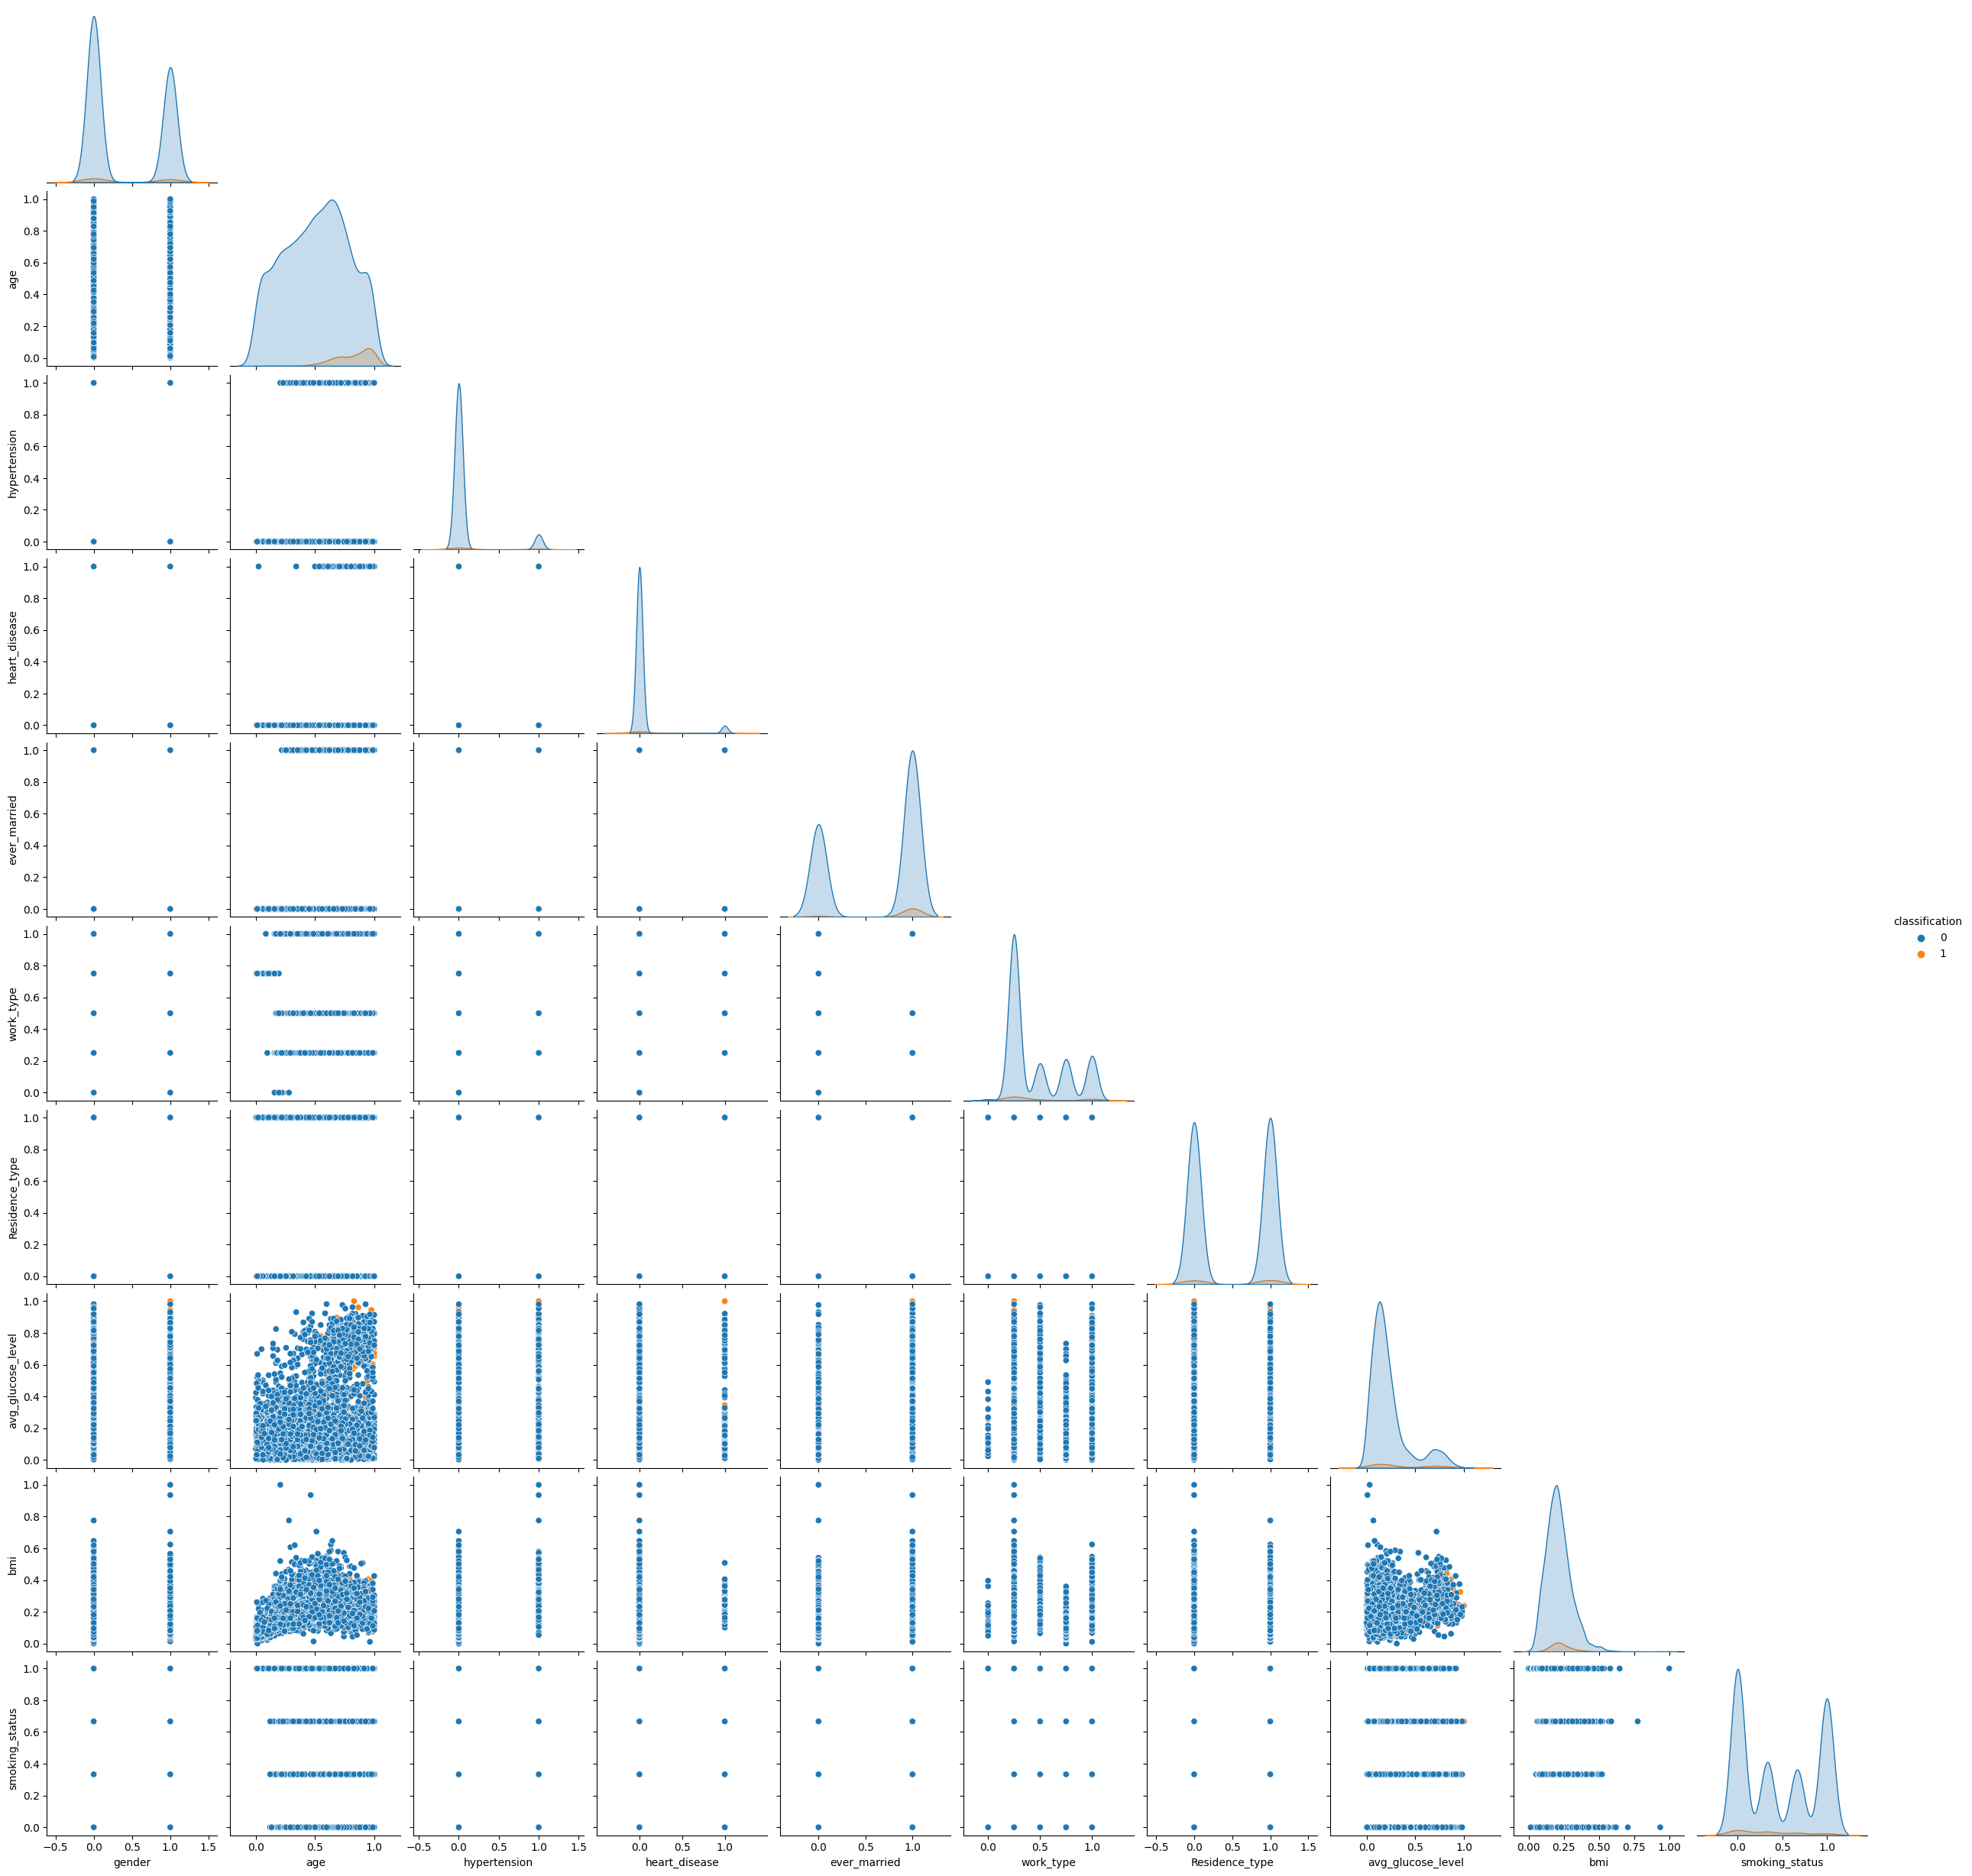

In [18]:
sns.pairplot(df, hue='classification', corner=True)
plt.show()

In [19]:
df.describe()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,classification
count,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000
mean,0.409739,0.522324,0.091891,0.049511,0.652812,0.467757,0.507335,0.231638,0.212996,0.459046,0.042584
std,0.491836,0.275343,0.288901,0.216954,0.476125,0.289659,0.499997,0.205085,0.089969,0.420877,0.201937
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.304199,0.000000,0.000000,0.000000,0.250000,0.000000,0.101318,0.151203,0.000000,0.000000
50%,0.000000,0.536133,0.000000,0.000000,1.000000,0.250000,1.000000,0.168775,0.203895,0.333333,0.000000
75%,1.000000,0.731445,0.000000,0.000000,1.000000,0.750000,1.000000,0.269481,0.261168,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
X = df[df.columns[:-1]].to_numpy(dtype=np.float32)

In [21]:
y = df['classification'].to_numpy(dtype=np.float32)

In [22]:
X.shape

(4908, 10)

In [23]:
y.shape

(4908,)

In [32]:
MANN = create_model(activations=[tf.nn.sigmoid, tf.nn.tanh, tf.nn.relu, tf.nn.elu, tf.nn.swish], dropout=True)
MANN.compile(optimizer=keras.optimizers.legacy.RMSprop(),
             loss=keras.losses.BinaryCrossentropy(),
             metrics=[keras.metrics.BinaryAccuracy()])

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [34]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(1000).batch(256)
test_dataset = test_dataset.batch(256)

In [35]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
MANN.fit(x=train_dataset, batch_size=32, epochs=100, validation_data=test_dataset, callbacks=[tensorboard_callback])

Epoch 1/100
16/16 [==============================] - 6s 93ms/step - loss: 0.7799 - binary_accuracy: 0.5168 - val_loss: 0.5033 - val_binary_accuracy: 0.8045
Epoch 2/100
16/16 [==============================] - 1s 34ms/step - loss: 0.7285 - binary_accuracy: 0.5471 - val_loss: 0.4883 - val_binary_accuracy: 0.8554
Epoch 3/100
16/16 [==============================] - 0s 30ms/step - loss: 0.7019 - binary_accuracy: 0.5851 - val_loss: 0.4818 - val_binary_accuracy: 0.9043
Epoch 4/100
16/16 [==============================] - 1s 35ms/step - loss: 0.6731 - binary_accuracy: 0.6215 - val_loss: 0.4845 - val_binary_accuracy: 0.9206
Epoch 5/100
16/16 [==============================] - 1s 36ms/step - loss: 0.6519 - binary_accuracy: 0.6396 - val_loss: 0.4855 - val_binary_accuracy: 0.9206
Epoch 6/100
16/16 [==============================] - 1s 35ms/step - loss: 0.6207 - binary_accuracy: 0.6826 - val_loss: 0.4922 - val_binary_accuracy: 0.9216
Epoch 7/100
16/16 [==============================] - 1s 36ms/ste

In [36]:
MANN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layers_multi_1 (MultiActiva  (None, 25)               275       
 tionLayer)                                                      
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 batch_normalization_5 (Batc  (None, 25)               100       
 hNormalization)                                                 
                                                                 
 layers_multi_2 (MultiActiva  (None, 20)               520       
 tionLayer)                                                      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                      

In [37]:
y_pred = np.where(MANN.predict(X_test) > 0.5, 1,0)

31/31 [==============================] - 1s 10ms/step


In [38]:
print(classification_report(y_test, y_pred, labels=[0, 1], target_names=['No Stroke', 'Stroke']))

              precision    recall  f1-score   support

   No Stroke       0.96      1.00      0.98       940
      Stroke       0.00      0.00      0.00        42

    accuracy                           0.96       982
   macro avg       0.48      0.50      0.49       982
weighted avg       0.92      0.96      0.94       982



C:\Users\Braden\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Braden\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Braden\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

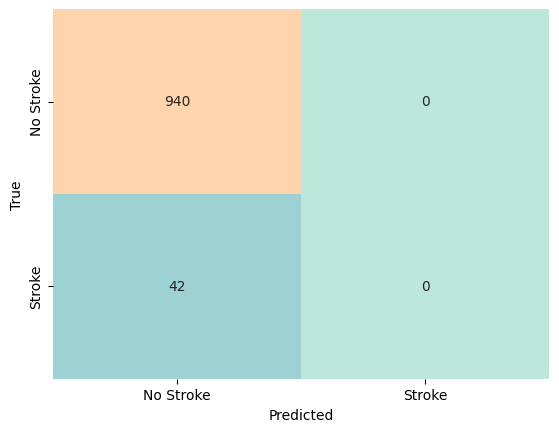

In [39]:
sns.heatmap(confusion_matrix(y_test, y_pred), cmap='icefire', annot=True, cbar=False,
            fmt='d',xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()